In [1]:
%pip install -q tqdm xarray graphviz dask zarr scipy netCDF4 joblib google-cloud-storage matplotlib gcsfs

Note: you may need to restart the kernel to use updated packages.


In [14]:
import contextlib
from datetime import timedelta, date
import logging
import multiprocessing
from os import system
from sys import platform
import time
import warnings

import dask
from dask.diagnostics import ProgressBar
from google.cloud import storage
import gcsfs
import numpy as np
from tqdm.notebook import tqdm
import joblib
from joblib import Parallel, delayed
import xarray as xr

In [3]:
start_date = date(1990, 1, 1)
end_date = date(2021, 1, 1)
daily_data_bucket = "rom-input"

xr.set_options(keep_attrs=True)
warnings.filterwarnings("ignore", category=FutureWarning)
if platform == "darwin":
    multiprocessing.set_start_method("fork", force=True)  # ipython bug workaround https://github.com/ipython/ipython/issues/12396
    
logging.basicConfig(filename="analysis.log", filemode="w", level=logging.INFO)

In [4]:
gcs = gcsfs.GCSFileSystem()
ds = xr.open_zarr(gcs.get_mapper(f'gs://{daily_data_bucket}/era5-daily'),
                  consolidated=True)

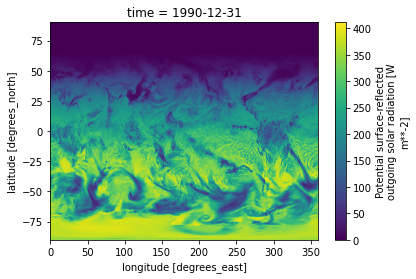

In [25]:
ds.psrosr[364, :, :].plot.imshow()

In [15]:
def mean(obj, dim):
    # note: apply always moves core dimensions to the end
    return apply_ufunc(np.nanmean, obj, input_core_dims=[[dim]], kwargs={"axis": -1})

In [84]:
ds.psrosr[33, :, :].min().compute()

<xarray.DataArray 'psrosr' ()>
array(-inf, dtype=float32)
Coordinates:
    time     datetime64[ns] 1990-02-03
Attributes:
    long_name:      Potential surface-reflected outgoing solar radiation
    standard_name:  toa_outgoing_shortwave_flux
    units:          W m**-2

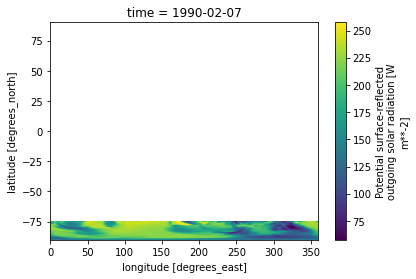

In [90]:
delayed_ds = ds.psrosr[37, :, :].plot.imshow()

In [56]:
delayed_ds.compute()

AttributeError: 'AxesImage' object has no attribute 'compute'

In [37]:
psrosr_nas

<xarray.DataArray 'psrosr' ()>
array(379995840)
Attributes:
    long_name:      Potential surface-reflected outgoing solar radiation
    standard_name:  toa_outgoing_shortwave_flux
    units:          W m**-2

In [17]:
with ProgressBar():
    ds_ann = delayed_average.compute()

[#####################################   ] | 92% Completed | 38.8s

/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:47: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


[########################################] | 100% Completed | 39.7s


In [10]:
ds_ltm

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
Data variables:
    psrosr     (latitude, longitude) float32 nan nan nan nan ... nan nan nan nan
    r          (latitude, longitude) float32 nan nan nan nan ... -inf -inf -inf
    srosr      (latitude, longitude) float32 nan nan nan nan ... nan nan nan nan
    ssrd       (latitude, longitude) float32 75.23 75.23 75.23 ... 129.9 129.9
    ssru       (latitude, longitude) float32 52.02 52.02 52.02 ... 108.7 108.7
    t          (latitude, longitude) float32 nan nan nan nan ... nan nan nan nan
    tisr       (latitude, longitude) float32 172.1 172.1 172.1 ... 173.2 173.2
    tosr       (latitude, longitude) float32 105.1 105.1 105.1 ... 124.6 124.6
Attributes:
    Conventions:  CF-1.6
    comment:      Hourly-mean ERA5 data was processed through Stephens et al....
    history:      2021-06-13 04:01:08 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...
    institution:  ECMWF
    source:       ERA5
    title:        Reflective Earth optimization map inputs

In [4]:
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Patch joblib to report into tqdm progress bar given as argument."""

    def tqdm_print_progress(self):
        if self.n_completed_tasks > tqdm_object.n:
            n_completed = self.n_completed_tasks - tqdm_object.n
            tqdm_object.update(n=n_completed)

    original_print_progress = joblib.parallel.Parallel.print_progress
    joblib.parallel.Parallel.print_progress = tqdm_print_progress

    try:
        yield tqdm_object
    finally:
        joblib.parallel.Parallel.print_progress = original_print_progress
        tqdm_object.close()


def daterange(start_date, end_date):
    """Make a date range object spanning two dates.
    
    Args:
        start_date: date object to start from.
        end_date: date object to end at.
    
    Yields:
        date object for iteration.
    """
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)


def get_date_data_gcs(single_date, bucket_name):
    """Download a dataset for a single date from Google Cloud Storage.
    
    Args:
        single_date: date object representing day to retrieve data for.
        bucket_name: Google Cloud Storage bucket to download from.
    
    Returns:
        Nothing; downloads data from Google Cloud Storage as a side effect.
    """
    client = storage.Client()
    bucket = client.get_bucket(bucket_name)    
    blob = bucket.blob(f"{single_date.strftime('%Y%m%d')}.nc")
    blob.download_to_filename(filename=f"./{single_date.strftime('%Y%m%d')}.nc")


def put_date_data_gcs(single_date, bucket_name):
    """Upload a dataset for a single date to Google Cloud Storage.
    
    Args:
        single_date: date object representing day to retrieve data for.
        bucket_name: Google Cloud Storage bucket to download from.
        
    Returns:
        Nothing; uploads data to Google Cloud Storage as a side effect.
    """
    client = storage.Client()
    bucket = client.get_bucket(bucket_name)    
    blob = bucket.blob(f"{single_date.strftime('%Y%m%d')}.nc")
    blob.upload_from_filename(filename=f"./{single_date.strftime('%Y%m%d')}.nc")
    

def check_blob_size(single_date, bucket_name, raise_threshold=1):
    """Verify that a GCS blob is larger than a specified threshold.
    
    Args:
        single_date: date object representing day to retrieve data for.
        bucket_name: Google Cloud Storage bucket to upload to.
        raise_threshold: file size below which an exception should be raised.
    """
    client = storage.Client()
    bucket = client.get_bucket(bucket_name)    
    blob = bucket.get_blob(f"{single_date.strftime('%Y%m%d')}.nc")
    if blob.size < raise_threshold:
        raise Exception(f"{single_date.strftime('%Y%m%d')} data file size is smaller than expected")
    else:
        logging.info(f"{single_date.strftime('%Y%m%d')} file size in GCS is {int(blob.size * 1e-6)}MB")


def modify_units(dataset, starting_units, ending_units, conversion_factor):
    """Modify the units of a variable.
    
    Args:
        dataset: xarray Dataset
        starting_units: str of units to be modified
        ending_units: str of units after modification
        conversion_factor: numerical factor to apply to convert units
    
    Returns:
        xarray Dataset with units modified for variables with units matching the starting unit.
    """
    for variable in dataset:
        if dataset[variable].attrs["units"] == starting_units:
            dataset[variable] = dataset[variable] * conversion_factor
            dataset[variable].attrs["units"] = ending_units
    return dataset

        
def compute_daily_average(dataset):
    """Compute the daily average and an input xarray dataset."""
    return dataset.resample(time='1D').sum() / dataset.sizes["time"]


def compute_boundary_fluxes(dataset):
    """Compute missing boundary fluxes at the surface and top of atmosphere if possible.
    
    Use available radiative fluxes e.g. net solar radiation and incoming solar radiation to 
    compute outgoing solar radiation.
    
    Args:
        dataset: xarray Dataset with radiative fluxes at the surface and top of atmosphere.
        
    Returns:
        xarray Dataset with missing fluxes at the boundaries.
    """
    if ("tosr" not in dataset) and all(x in dataset for x in ["tisr", "tsr"]):
        dataset["tosr"] = dataset["tisr"] - dataset["tsr"]
        dataset["tosr"].attrs["long_name"] = "TOA outgoing solar radiation"
        dataset["tosr"].attrs["standard_name"] = "toa_outgoing_shortwave_flux"
    if ("ssru" not in dataset) and all(x in dataset for x in ["ssrd", "ssr"]):
        dataset["ssru"] = dataset["ssrd"] - dataset["ssr"]
        dataset["ssru"].attrs["long_name"] = "Surface solar radiation upwards"
        dataset["ssru"].attrs["standard_name"] = "surface_upwelling_shortwave_flux_in_air"
    return dataset


def compute_radiative_properties(dataset):
    """Compute new variables based on the model of Stephens et al. (2015)."""
    # System properties
    dataset["R"] = dataset["tosr"] / dataset["tisr"]
    dataset["R"].attrs["long_name"] = "Planetary albedo"
    dataset["R"].attrs["standard_name"] = "planetary_albedo"
    dataset["R"].attrs["units"] = "1"
    
    dataset["T"] = dataset["ssrd"] / dataset["tisr"]
    dataset["T"].attrs["long_name"] = "Planetary transmission"
    dataset["T"].attrs["standard_name"] = "planetary_transmittance"
    dataset["T"].attrs["units"] = "1"
    
    dataset["alpha"] = dataset["ssru"] / dataset["ssrd"]
    dataset["alpha"].attrs["long_name"] = "Surface albedo"
    dataset["alpha"].attrs["standard_name"] = "surface_albedo"
    dataset["alpha"].attrs["units"] = "1"

    # Intrinsic properties
    dataset["t"] = ((1 - dataset["alpha"] * dataset["R"]) / 
                    (1 - dataset["alpha"]**2 * dataset["T"]**2))
    dataset["t"].attrs["long_name"] = "1-layer atmospheric transmission"
    dataset["t"].attrs["standard_name"] = "atmosphere_transmittance"
    dataset["t"].attrs["units"] = "1"
    
    dataset["r"] = dataset["R"] - dataset["t"] * dataset["alpha"] * dataset["T"]
    dataset["r"].attrs["long_name"] = "1-layer atmosphere reflectivity"
    dataset["r"].attrs["standard_name"] = "atmosphere_reflectance"
    dataset["r"].attrs["units"] = "1"

    # Reflective properties
    dataset["srosr"] = dataset["tisr"] * (dataset["R"] - dataset["r"])
    dataset["srosr"].attrs["long_name"] = "Surface-reflected outgoing solar radiation"
    dataset["srosr"].attrs["standard_name"] = "toa_outgoing_shortwave_flux"
    dataset["srosr"].attrs["units"] = "J m**-2"
    
    dataset["psrosr"] = dataset["ssrd"] * dataset["t"]
    dataset["psrosr"].attrs["long_name"] = "Potential surface-reflected outgoing solar radiation"
    dataset["psrosr"].attrs["standard_name"] = "toa_outgoing_shortwave_flux"
    dataset["psrosr"].attrs["units"] = "J m**-2"
    
    return dataset


def drop_unneccesary_variables(dataset, keep_vars):
    """Drop variables not specified as necessary.
    
    Args:
        dataset: xarray Dataset.
        keep_vars: list of variables to keep.
    
    Returns:
        xarray Dataset with specified variables.
    """
    drop_vars = list(set(dataset.data_vars).symmetric_difference(set(keep_vars)))
    return dataset.drop_vars(drop_vars)


def analyze_daily_data(single_date, raw_data_bucket, analyzed_data_bucket, cleanup=False):
    """Process hourly average data into daily average data.
    
    Args:
        single_date: date object representing day to retrieve data for.
        raw_data_bucket: str name of Google Cloud Storage bucket for raw daily data.
        analyzed_data_bucket: str name of Google Cloud Storage bucket for analzyed daily data.
        cleanup: boolean option to remove downloaded data after processing.
        
    Raises:
        Exception: if the same bucket is provided for both raw and analyzed data.
    """
    get_date_data_gcs(single_date, hourly_data_bucket)
    
    with xr.open_dataset(f"./{single_date.strftime('%Y%m%d')}.nc") as ds:
        ds = compute_boundary_fluxes(ds)
        ds = compute_radiative_properties(ds)
        ds = drop_unneccesary_variables(ds, keep_vars=["ssrd", "ssru", "tisr", "tosr", 
                                                       "t", "r", "srosr", "psrosr"])
        ds = compute_daily_average(ds)
        ds = modify_units(ds, "J m**-2", "W m**-2", (1 / 3600))  # 3600 seconds in an hour
        ds.to_netcdf(f"./{single_date.strftime('%Y%m%d')}.nc")

    put_date_data_gcs(single_date, daily_data_bucket)
    check_blob_size(single_date, daily_data_bucket, raise_threshold=1e+7)
    
    if cleanup:
        system(f"rm {single_date.strftime('%Y%m%d')}.nc")

In [5]:
get_date_data_gcs(start_date, daily_data_bucket)

In [6]:
ds = xr.open_dataset(f"./{start_date.strftime('%Y%m%d')}.nc")